In [3]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# On commence par l'énergie

In [3]:
data=pd.read_csv("cleaneddata.csv")

In [4]:
data=data.reset_index(drop=True)


In [5]:
data=data.iloc[np.random.permutation(data.index)].reset_index(drop=True)
#On mélange le dataset pour la sélection de Xtrain et Xtest pour la sélection des features
data.head()

,Unnamed: 0,OSEBuildingID,BuildingType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,OtherFuelUse(kBtu)
0,692,19669,0,47.627505,-122.327342,1910,1.0,5.0,0.000000,10.608786,0.0,0.000000,3.257117,99.0,1441393.25,0.288931,0.711069,57.335,0.0
1,1932,23937,0,47.682334,-122.264718,1979,1.0,5.0,0.000000,11.424750,0.0,0.000000,3.380053,76.0,2508079.75,1.000000,0.000000,17.485,0.0
2,2930,27652,0,47.626727,-122.349372,2006,1.0,3.0,10.072956,11.798743,0.0,0.000000,3.485077,96.0,5683518.75,0.620978,0.379022,139.015,0.0
3,627,838,1,47.611421,-122.321337,1928,1.0,3.0,9.647304,11.126807,0.0,10.657918,3.202709,54.0,6668456.00,0.399050,0.600950,231.390,0.0
4,793,19893,0,47.614551,-122.335241,2002,1.0,6.0,9.845541,11.281611,0.0,0.000000,3.271127,81.0,2018765.75,0.632863,0.367137,48.270,0.0


In [6]:
#On commence par l'énergie
data=data[data.columns.tolist()[2:]]

In [7]:
#Après quelques essais avec ou sans ESS, la prédiction de l'énergie est bien meilleure avec ESS
#Et on ne nous demande d'étudier ESS que pour les émissions:

data.dropna(how='any',inplace=True)

X=data.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y=data['SiteEnergyUse(kBtu)']



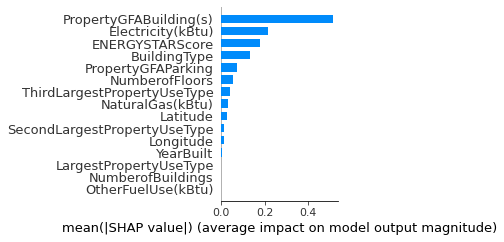

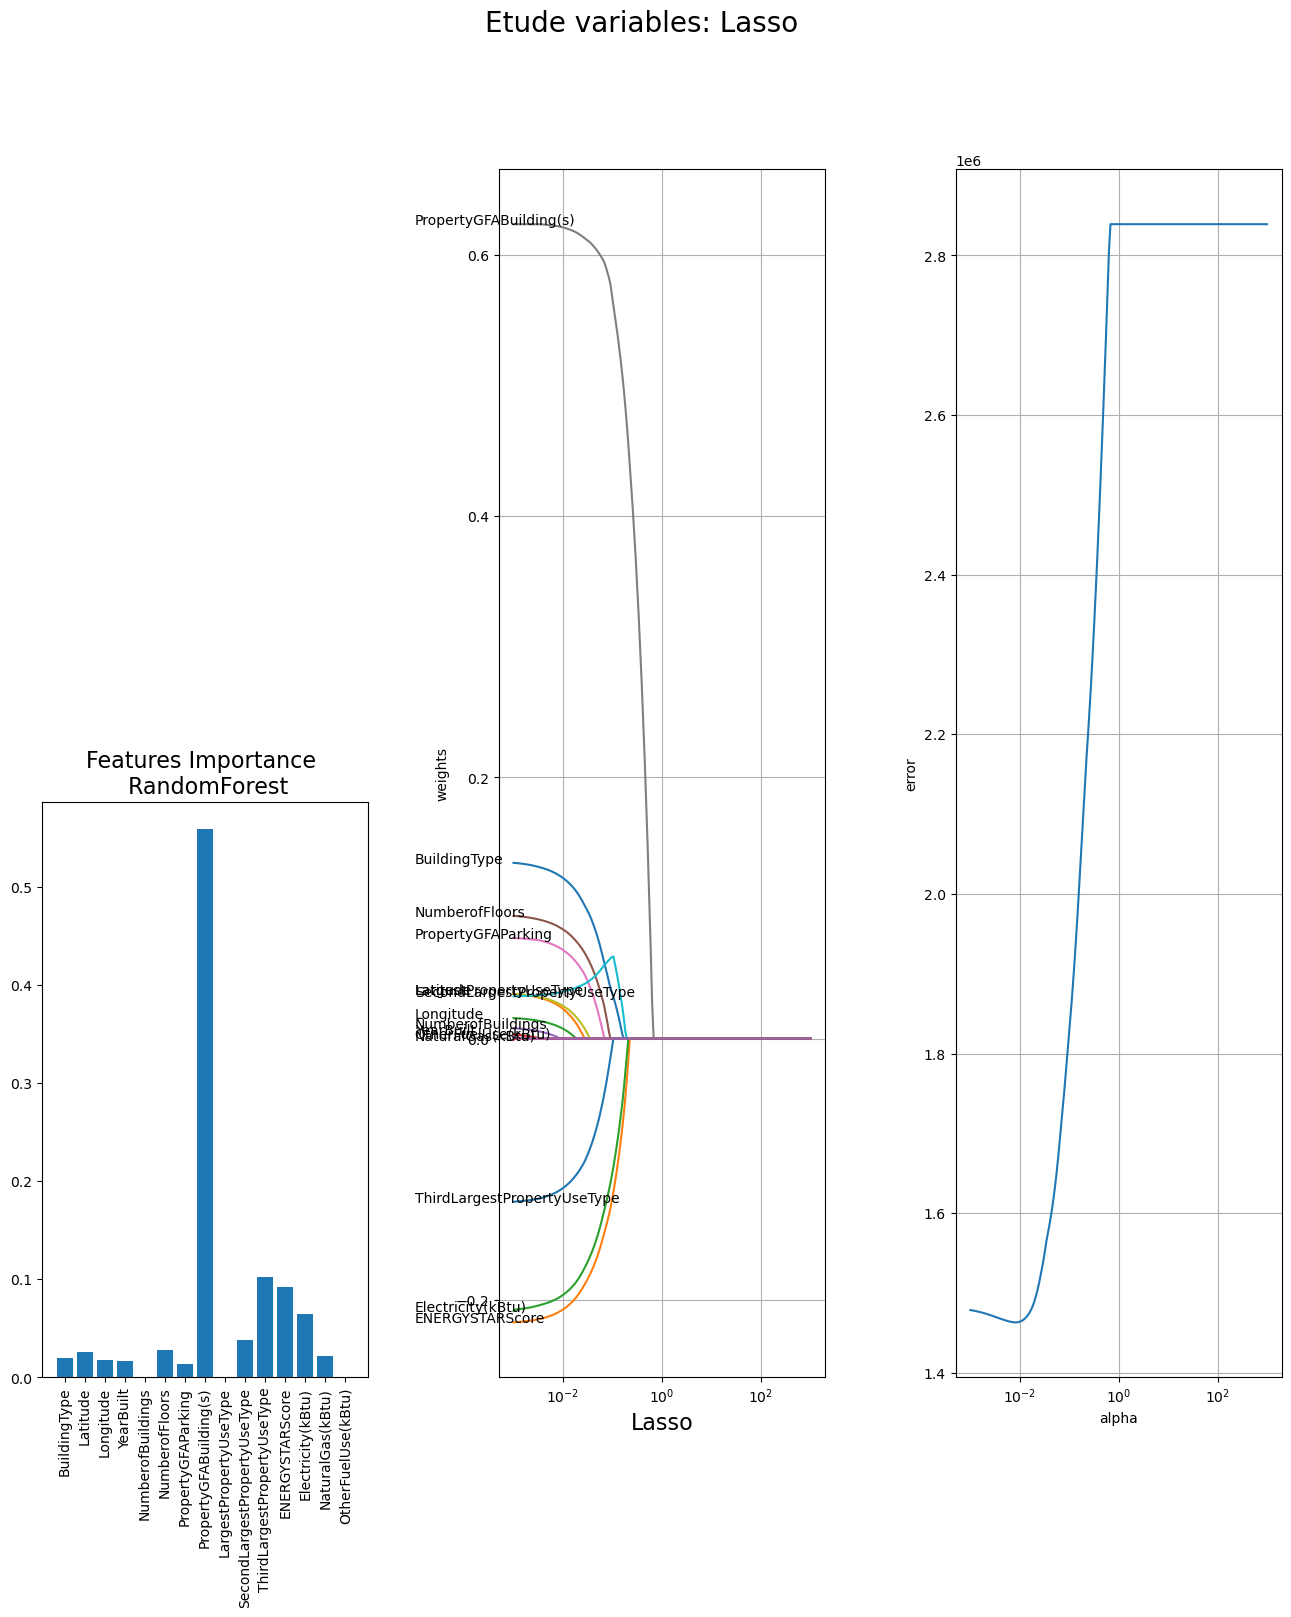

,R2,RMSE,MAE,MSLE
Dummy,-1.486846e+32,2.839051e+06,1.693402e+06,0.776284
Régression Simple,5.985233e-01,1.479445e+06,7.906859e+05,0.192749
Régression Ridge,5.810977e-01,1.485831e+06,7.912428e+05,0.193195
Régression Lasso,-5.289863e-01,1.827681e+06,9.362064e+05,0.253743
Random Forrest,6.202420e-01,1.282930e+06,6.773343e+05,0.167045


In [74]:
#Je recrée mes échantillon test en prenant les 1600 premiere lignes pour le train et le reste pour le test:
X=data.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y=data['SiteEnergyUse(kBtu)']

#J'enlève les features pour voir l'effet sur les prédictions:
X.drop(['NumberofBuildings','OtherFuelUse(kBtu)','Longitude','LargestPropertyUseType','NaturalGas(kBtu)'],axis=1,inplace=True)

#Je relance mes algorithmes
from sklearn.preprocessing import StandardScaler

#On standardise
Xtrain=X.iloc[1:1600,:]
Xtest=X.iloc[1600:,:]

std=StandardScaler()
std.fit(Xtrain)
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log(y.iloc[1:1600])
y_test=y.iloc[1600:]


from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

Result=pd.DataFrame({'R2':[],'RMSE':[],'MAE':[],'MSLE':[]})


dum_sans=DummyRegressor(strategy='mean')
dum_sans.fit(X_train,y_train)
#On passe à l'exponentielle pour comparer avec les valeurs test qui n'ont pas été passées au log
y_pred=np.exp(dum_sans.predict(X_test))
    
result.loc['Dummy']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})


import shap
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
    
lr.fit(X_train,y_train)
y_pred=np.exp(lr.predict(X_test))

explainer= shap.LinearExplainer(lr,X_train,1000)
shap_values= explainer.shap_values(X_train)

fig=plt.figure(figsize=(14,6))

grid=plt.GridSpec(2,3,wspace=0.4,hspace=0.1)

plt.subplot(grid[0,0])
shap.summary_plot(shap_values, X.columns, plot_type="bar")
#On va faire un Ridge CV en regardant un peu l'efficacité des variables:
from sklearn.linear_model import RidgeCV

lr=RidgeCV(alphas=np.logspace(-1,3,200),cv=10)
    
lr.fit(X_train,y_train)
y_pred=np.exp(lr.predict(X_test))
    
result.loc['Régression Ridge']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

from sklearn.linear_model import LassoCV



lr=LassoCV(alphas=np.logspace(-1,3,200),cv=10)
    
lr.fit(X_train,y_train)
y_pred=np.exp(lr.predict(X_test))

result.loc['Régression Lasso']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

#On va regarder un peu plus les variables:
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)

from sklearn.linear_model import Lasso

lasso = Lasso()
    
i=0
coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train,y_train)
    y_pred=np.exp(lasso.predict(X_test))
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred - y_test) ** 2)**0.5)

fig = plt.figure(2, figsize=(16, 16), frameon=False, dpi=100)
k=1
plt.suptitle('Etude variables: Lasso',size=20)

plt.subplot(grid[:,1])
ax = plt.gca()
for i in range(X.shape[1]):
    ax.plot(alphas, [coefs[k][i] for k in range(200)])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.xlabel('Lasso',size=16)
plt.ylabel('weights')
plt.axis('tight')
plt.grid(True)
#On affiche le nom de la feature avec ciefs[0][i]
for i in range(X.shape[1]):
    plt.text(0.00001, coefs[0][i], X.columns.tolist()[i],transform=ax.transData)
    

plt.subplot(grid[:,2])
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.grid(True)


#On va faire un randomForrestRegressor:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=1000)

rf.fit(X_train, y_train)
y_pred=np.exp(rf.predict(X_test))

result.loc['Random Forrest']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

plt.subplot(grid[1,0])

plt.bar(range(len(X.columns.tolist())),rf.feature_importances_,)
plt.title('Features Importance \n RandomForest',size=16)
plt.xticks(range(len(X.columns.tolist())),X.columns.tolist(),rotation=90)

plt.show() 

result

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

params={'n_estimators':[500,1000,5000], 
            'learning_rate': [0.05,0.02,0.01]}

grid = GridSearchCV(GradientBoostingRegressor(),params,cv=2,scoring='r2')
grid.fit(X_train, y_train)
    
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))



The optimal parameters are {'learning_rate': 0.02, 'n_estimators': 1000} with a score of 0.83


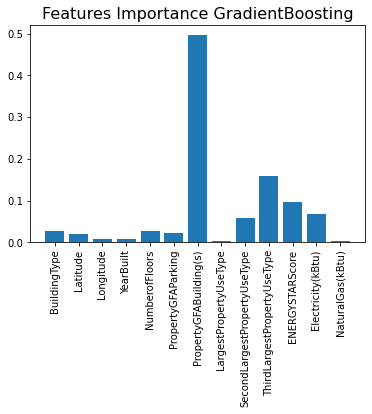

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

grid=GradientBoostingRegressor(n_estimators=1000,learning_rate=0.02)
grid.fit(X_train, y_train)

plt.bar(range(len(X.columns.tolist())),grid.feature_importances_,)
plt.title('Features Importance GradientBoosting',size=16)
plt.xticks(range(len(X.columns.tolist())),X.columns.tolist(),rotation=90)

plt.show() 

In [77]:
import pandas as pd

%pylab inline
#On part donc sur quelque chose sans Number of Buildings ni OtherFuelUse
data=pd.read_csv("cleaneddata.csv")

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['std', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [71]:
data.head()

,Unnamed: 0,OSEBuildingID,BuildingType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,OtherFuelUse(kBtu)
0,0,1,1,47.612195,-122.337994,1927,1.0,12.0,0.000000,11.390012,0.0,0.000000,3.374911,62.0,7103895.25,0.537178,0.179396,249.705,0.0
1,1,2,1,47.613138,-122.333644,1996,1.0,11.0,9.620129,11.390780,0.0,8.438799,3.367069,56.0,8371084.00,0.426957,0.573043,279.685,0.0
2,5,9,1,47.616334,-122.336667,1999,1.0,2.0,10.524037,11.003599,0.0,0.000000,3.375573,NaN,12069300.00,0.606591,0.393409,303.215,0.0
3,6,10,1,47.614007,-122.332785,1926,1.0,11.0,0.000000,11.326692,0.0,0.000000,3.362522,26.0,6005818.50,0.457129,0.542871,192.300,0.0
4,7,11,1,47.613086,-122.331335,1926,1.0,8.0,0.000000,11.540161,0.0,0.000000,3.397083,NaN,6362076.75,0.608650,0.055034,210.750,0.0


In [6]:
data.shape

(2692, 19)

In [78]:
#On va commencer par effectuer les différences régression avec l'EnergyStarScore:
#On commence par l'énergie
data=data[data.columns.tolist()[2:]]
data.drop(['NumberofBuildings','OtherFuelUse(kBtu)'],axis=1,inplace=True)

In [79]:
#Après quelques essais avec ou sans ESS, la prédiction de l'énergie est bien meilleure avec ESS
#Et on ne nous demande d'étudier ESS que pour les émissions:

data.dropna(how='any',inplace=True)

X=data.drop(['NaturalGas(kBtu)','LargestPropertyUseType','Longitude','YearBuilt','SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y=data['SiteEnergyUse(kBtu)']


y.describe()

count    2.089000e+03
mean     2.571402e+06
std      2.629372e+06
min      8.126790e+04
25%      8.792882e+05
50%      1.588275e+06
75%      3.037691e+06
max      1.754948e+07
Name: SiteEnergyUse(kBtu), dtype: float64

In [80]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xtrain,Xtest,ytrain,y_test=train_test_split(X,y,test_size=0.25)

std=StandardScaler()
std.fit(Xtrain)
#On standardise
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log(ytrain)


In [81]:
#On va effectuer quelques GridSearch pour sélectionner des hyperparamètre en KernelRidge, SVR
#On va prendre comme scoring la R2:

Score=pd.DataFrame({'Best Parameters':[],'R2':[]})

In [82]:
#KernelRidge:
#Linear pas de bons scores
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

for i in ['rbf', 'sigmoid']:
    params={'gamma':np.logspace(-8, -2, 6),'alpha':np.logspace(-6, -3, 8)}

    kr = GridSearchCV(KernelRidge(kernel=i),params,cv=2,scoring='r2')
    kr.fit(X_train, y_train)
    
    k='KernelRidge '+i
    Score.loc[k]=pd.Series({'Best Parameters':kr.best_params_,'R2':kr.best_score_})
    print("The optimal parameters are {} with a score of {:.2f}".format(kr.best_params_, kr.best_score_))

The optimal parameters are {'alpha': 0.00013894954943731373, 'gamma': 0.000630957344480193} with a score of 0.82


/home/samuel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/samuel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/samuel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/samuel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/samuel/anacond

/home/samuel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/samuel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The optimal parameters are {'alpha': 7.196856730011514e-06, 'gamma': 2.5118864315095823e-06} with a score of 0.79


In [83]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

params={'degree':[2,3,4,5],'gamma':np.logspace(-5, -1, 6),'alpha':np.logspace(-4, 2, 6)}

kr = GridSearchCV(KernelRidge(kernel='poly'),params,cv=2,scoring='r2')
kr.fit(X_train, y_train)
Score.loc['KernelRidge Polynomiale']=pd.Series({'Best Parameters':kr.best_params_,'R2':kr.best_score_})


In [41]:
Score

,Best Parameters,R2
KernelRidge rbf,"{'alpha': 7.196856730011514e-06, 'gamma': 0.00...",0.822409
KernelRidge sigmoid,"{'alpha': 1e-06, 'gamma': 0.000630957344480193}",0.817690
KernelRidge Polynomiale,"{'alpha': 0.001584893192461114, 'degree': 4, '...",0.823719


In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

for i in ['linear', 'rbf', 'sigmoid']:
    params={'gamma':np.logspace(-6, -1, 4),'C':np.logspace(1, 3, 4)}

    grid = GridSearchCV(SVR(kernel=i),params,cv=2,scoring='r2')
    print(i)
    grid.fit(X_train, y_train)
    
    k='SVR '+i
    Score.loc[k]=pd.Series({'Best Parameters':grid.best_params_,'R2':grid.best_score_})
    print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))
    

linear
The optimal parameters are {'C': 215.44346900318823, 'gamma': 1e-06} with a score of 0.78
rbf
The optimal parameters are {'C': 1000.0, 'gamma': 0.0021544346900318843} with a score of 0.83
sigmoid
The optimal parameters are {'C': 10.0, 'gamma': 0.0021544346900318843} with a score of 0.78


In [85]:
#On regarde un peu mieux le rbf en élargissant le 'C':
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

for i in ['rbf']:
    params={'gamma':np.logspace(-6, -1, 4),'C':np.logspace(2, 6, 5)}

    grid = GridSearchCV(SVR(kernel=i),params,cv=2,scoring='r2')
    print(i)
    grid.fit(X_train, y_train)
    
    k='SVR '+i
    Score.loc[k]=pd.Series({'Best Parameters':grid.best_params_,'R2':grid.best_score_})
    print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))


rbf
The optimal parameters are {'C': 1000.0, 'gamma': 0.0021544346900318843} with a score of 0.83


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

params={'C':np.logspace(-2, 3, 2)}

grid = GridSearchCV(SVR(kernel='poly',degree=4,gamma='auto'),params,cv=2,scoring='r2')
grid.fit(X_train, y_train)
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))


The optimal parameters are {'C': 0.01} with a score of -4.73


In [90]:
for i in range(Score.shape[0]):
    print(Score.iloc[i]['Best Parameters'])

{'alpha': 0.00013894954943731373, 'gamma': 0.000630957344480193}
{'alpha': 7.196856730011514e-06, 'gamma': 2.5118864315095823e-06}
{'alpha': 0.025118864315095794, 'degree': 3, 'gamma': 0.01584893192461114}
{'C': 215.44346900318823, 'gamma': 1e-06}
{'C': 1000.0, 'gamma': 0.0021544346900318843}
{'C': 10.0, 'gamma': 0.0021544346900318843}


In [91]:
Score

,Best Parameters,R2
KernelRidge rbf,"{'alpha': 0.00013894954943731373, 'gamma': 0.0...",0.822620
KernelRidge sigmoid,"{'alpha': 7.196856730011514e-06, 'gamma': 2.51...",0.786710
KernelRidge Polynomiale,"{'alpha': 0.025118864315095794, 'degree': 3, '...",0.826718
SVR linear,"{'C': 215.44346900318823, 'gamma': 1e-06}",0.779699
SVR rbf,"{'C': 1000.0, 'gamma': 0.0021544346900318843}",0.826021
SVR sigmoid,"{'C': 10.0, 'gamma': 0.0021544346900318843}",0.779433


In [103]:
X.columns

Index(['BuildingType', 'Latitude', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'Electricity(kBtu)'],
      dtype='object')

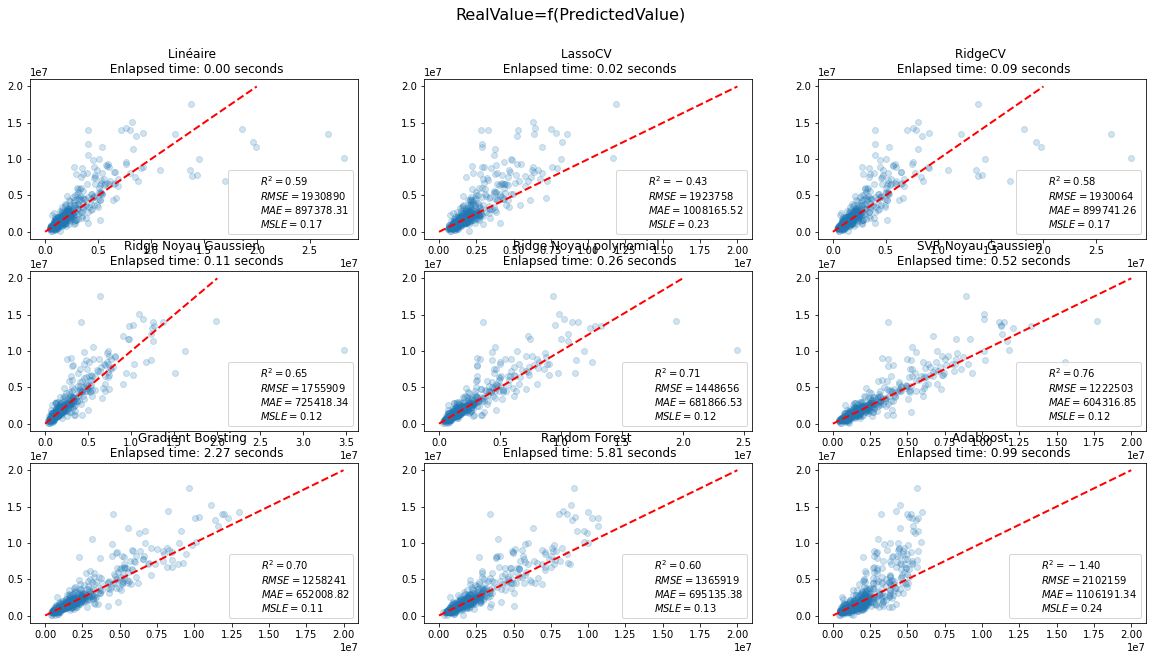

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR #OK
from sklearn.kernel_ridge import KernelRidge#OK
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV#OK
from sklearn.ensemble import GradientBoostingRegressor#OK
from sklearn.ensemble import RandomForestRegressor#OK
from sklearn.ensemble import AdaBoostRegressor#OK
import time
import xgboost

Xtrain,Xtest,ytrain,y_test=train_test_split(X,y,test_size=0.25)

std=StandardScaler()
std.fit(Xtrain)
#On standardise
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log(ytrain)


regressors=[LinearRegression(),LassoCV(alphas=np.logspace(-1,3,10),cv=5)\
            ,RidgeCV(np.logspace(-1,3,10),cv=5),KernelRidge(kernel='rbf',alpha=0.0001,gamma=0.006),\
           KernelRidge(kernel='poly',degree=3,alpha=0.025,gamma=0.015),SVR(kernel='rbf',gamma=0.002,C=1000),\
           GradientBoostingRegressor(n_estimators=1000,learning_rate=0.02),RandomForestRegressor(n_estimators=1000),\
            AdaBoostRegressor(n_estimators=500)]

name=['Linéaire','LassoCV','RidgeCV','Ridge Noyau Gaussien','Ridge Noyau polynomial','SVR Noyau Gaussien',\
     'Gradient Boosting','Random Forest','Adaboost']

Result=pd.DataFrame({'R2':[],'RMSE':[],'MAE':[],'MSLE':[],'Temps':[]})

k=1

fig=plt.figure(figsize=(20,10))
plt.suptitle('RealValue=f(PredictedValue)',size=16)

for i in range(9):
    start=time.time()
    estimator=regressors[i]
    estimator.fit(X_train,y_train)
    y_pred=np.exp(estimator.predict(X_test))
    
    t=time.time()-start
    R2=r2_score(y_pred,y_test)
    MSE=mean_squared_error(y_pred,y_test)
    MAE=mean_absolute_error(y_pred,y_test)
    MSLE=mean_squared_log_error(y_pred,y_test)
    
    
    Result.loc[name[i]]=pd.Series({'R2':R2,'RMSE':MSE**0.5,'MAE':MAE,'MSLE':MSLE,'Temps':t})

    plt.subplot(3,3,k)
    plt.plot([0,20000000],[0,20000000],'--r', linewidth=2)
    plt.scatter(y_pred,y_test,alpha=0.2)
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
    plt.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.0f}$'+ '\n' + r'$MAE={:.2f}$'+ '\n' + r'$MSLE={:.2f}$').\
                 format(R2,MSE**0.5,MAE,MSLE)], loc='lower right')
    
    plt.title(('{} \n Enlapsed time: {:.2f} seconds').format(name[i],t),size=12)
    
    k+=1
    
plt.show()

# On passe aux émissions de CO2

## On commence par conserver l'ESS

In [157]:

data=pd.read_csv("cleaneddata.csv")

In [158]:
data=data.reset_index(drop=True)


In [159]:
data=data.iloc[np.random.permutation(data.index)].reset_index(drop=True)
#On mélange le dataset pour la sélection de Xtrain et Xtest pour la sélection des features
data.head()

,Unnamed: 0,OSEBuildingID,BuildingType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,OtherFuelUse(kBtu)
0,2851,27300,0,47.731503,-122.314020,1966,1.0,4.0,9.013352,11.967073,0.0,0.0,3.478763,69.0,4.367505e+06,1.000000,0.0,30.445,0.0
1,295,429,1,47.611105,-122.342144,1923,1.0,11.0,0.000000,11.540988,0.0,0.0,3.395089,96.0,5.006298e+06,0.366789,0.0,257.490,0.0
2,2001,24170,1,47.700076,-122.303131,1974,1.0,2.0,0.000000,10.097861,0.0,0.0,3.177720,83.0,9.940243e+05,1.000000,0.0,6.930,0.0
3,1541,22460,0,47.656604,-122.387805,1968,1.0,4.0,0.000000,10.074411,0.0,0.0,3.174028,82.0,5.789404e+05,1.000000,0.0,4.035,0.0
4,916,20252,0,47.658929,-122.316333,1962,1.0,5.0,0.000000,10.344159,0.0,0.0,3.216239,98.0,6.730884e+05,1.000000,0.0,4.695,0.0


In [160]:
data=data[data.columns.tolist()[2:]]

In [161]:
#Après quelques essais avec ou sans ESS, la prédiction de l'énergie est bien meilleure avec ESS
#Et on ne nous demande d'étudier ESS que pour les émissions:

data.dropna(how='any',inplace=True)

X=data.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y=data['TotalGHGEmissions']

y

0        30.445
1       257.490
2         6.930
3         4.035
4         4.695
         ...   
2686     51.030
2688     95.895
2689     55.445
2690      9.020
2691      4.255
Name: TotalGHGEmissions, Length: 2089, dtype: float64

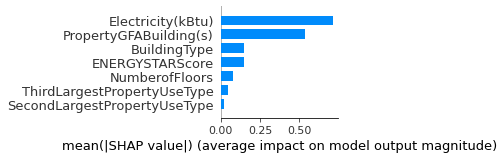

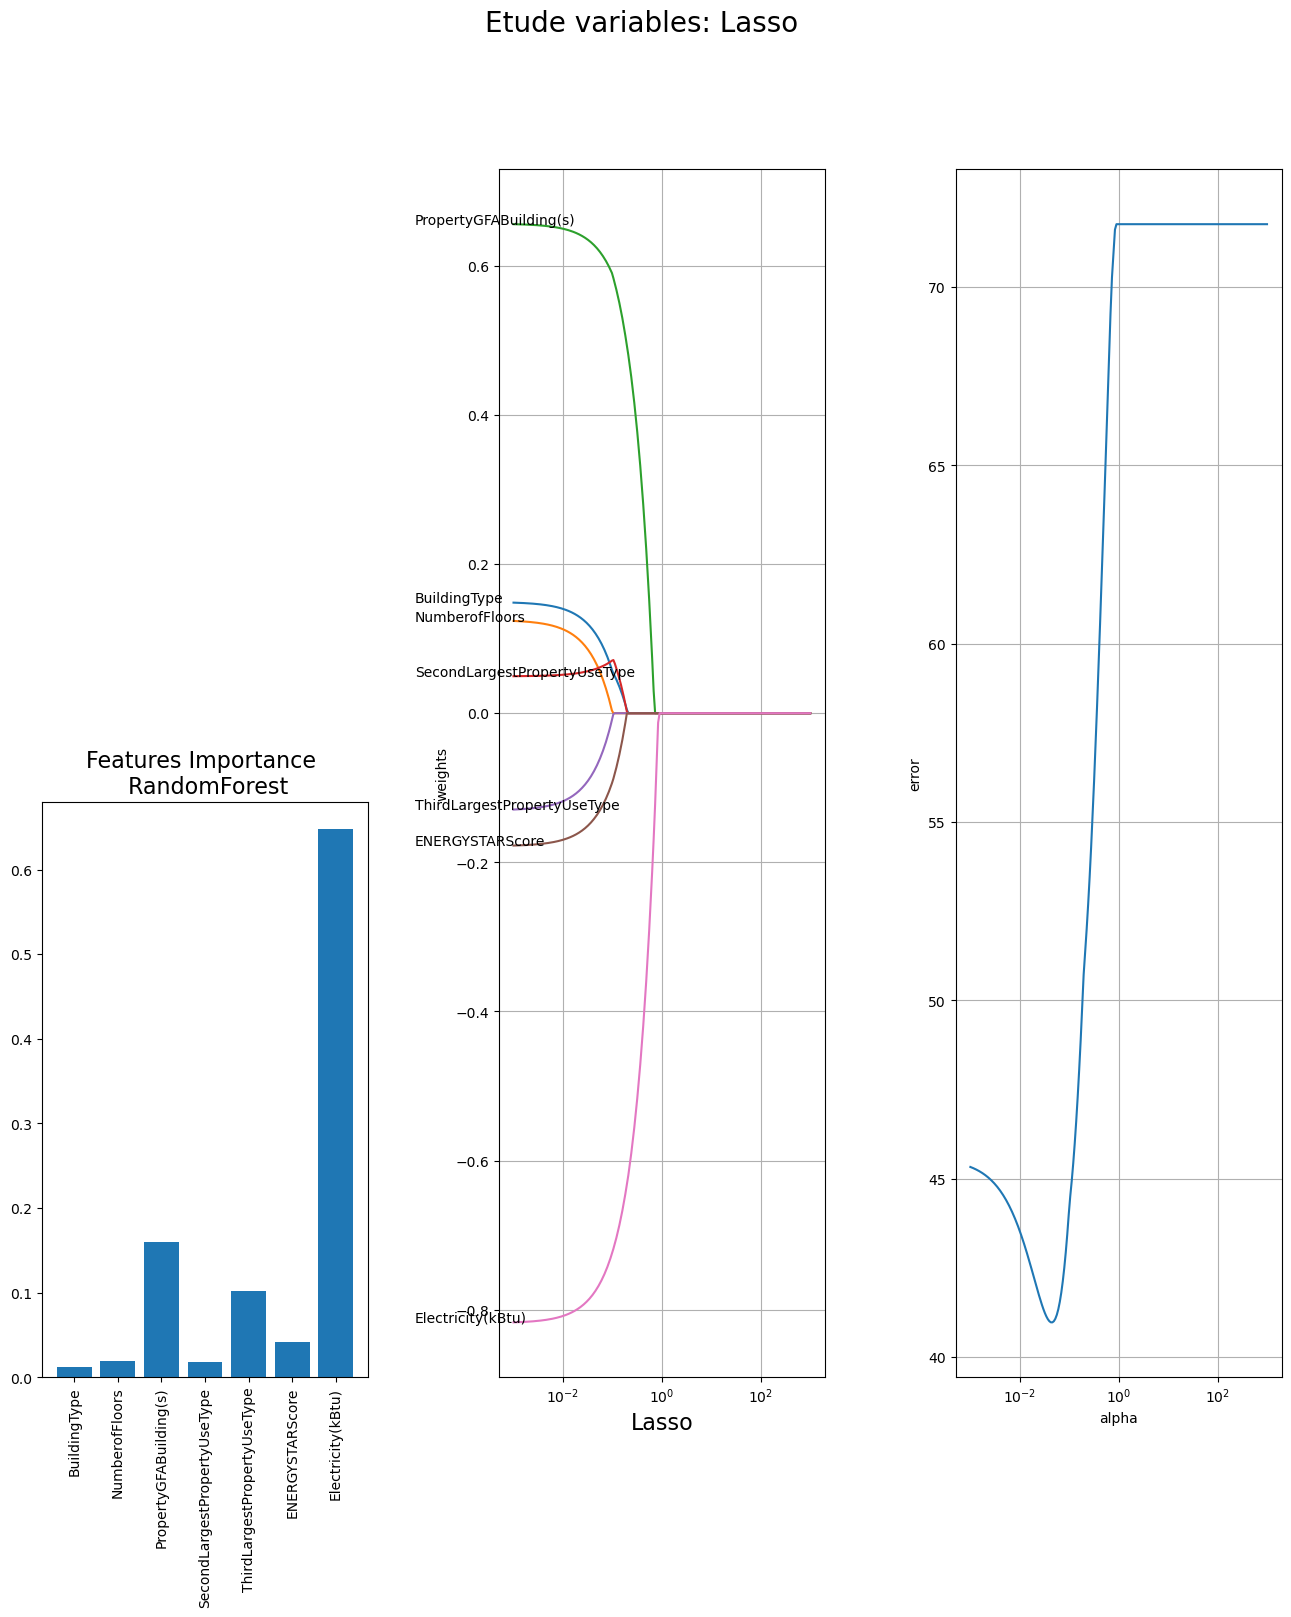

,R2,RMSE,MAE,MSLE
Dummy,-4.533432e+31,71.762084,41.418557,1.372930
Regression Simple,6.196034e-01,45.566633,19.072084,0.197203
Régression Ridge,6.190087e-01,45.189878,19.011014,0.197041
Régression Lasso,1.209052e-01,44.202144,20.230967,0.246954
Random Forrest,7.113487e-01,29.264451,15.006888,0.153845


In [182]:
#Je recrée mes échantillon test en prenant les 1600 premiere lignes pour le train et le reste pour le test:
X=data.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y=data['TotalGHGEmissions']

#J'enlève les features pour voir l'effet sur les prédictions:
X.drop(['NumberofBuildings','Latitude','PropertyGFAParking','LargestPropertyUseType','OtherFuelUse(kBtu)','YearBuilt','Longitude','NaturalGas(kBtu)'],axis=1,inplace=True)

#Je relance mes algorithmes
from sklearn.preprocessing import StandardScaler

#On standardise
Xtrain=X.iloc[1:1600,:]
Xtest=X.iloc[1600:,:]

std=StandardScaler()
std.fit(Xtrain)
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log1p(y.iloc[1:1600])
y_test=y.iloc[1600:]


from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

result=pd.DataFrame({'R2':[],'RMSE':[],'MAE':[],'MSLE':[]})


dum_sans=DummyRegressor(strategy='mean')
dum_sans.fit(X_train,y_train)
#On passe à l'exponentielle pour comparer avec les valeurs test qui n'ont pas été passées au log
y_pred=np.expm1(dum_sans.predict(X_test))
    
result.loc['Dummy']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})


import shap
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
    
lr.fit(X_train,y_train)
y_pred=np.expm1(lr.predict(X_test))

result.loc['Regression Simple']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})


explainer= shap.LinearExplainer(lr,X_train,1000)
shap_values= explainer.shap_values(X_train)

fig=plt.figure(figsize=(14,6))

grid=plt.GridSpec(2,3,wspace=0.4,hspace=0.1)

plt.subplot(grid[0,0])
shap.summary_plot(shap_values, X.columns, plot_type="bar")
#On va faire un Ridge CV en regardant un peu l'efficacité des variables:
from sklearn.linear_model import RidgeCV

lr=RidgeCV(alphas=np.logspace(-1,3,200),cv=10)
    
lr.fit(X_train,y_train)
y_pred=np.expm1(lr.predict(X_test))
    
result.loc['Régression Ridge']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

from sklearn.linear_model import LassoCV



lr=LassoCV(alphas=np.logspace(-1,3,200),cv=10)
    
lr.fit(X_train,y_train)
y_pred=np.expm1(lr.predict(X_test))

result.loc['Régression Lasso']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

#On va regarder un peu plus les variables:
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)

from sklearn.linear_model import Lasso

lasso = Lasso()
    
i=0
coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train,y_train)
    y_pred=np.expm1(lasso.predict(X_test))
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred - y_test) ** 2)**0.5)

fig = plt.figure(2, figsize=(16, 16), frameon=False, dpi=100)
k=1
plt.suptitle('Etude variables: Lasso',size=20)

plt.subplot(grid[:,1])
ax = plt.gca()
for i in range(X.shape[1]):
    ax.plot(alphas, [coefs[k][i] for k in range(200)])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.xlabel('Lasso',size=16)
plt.ylabel('weights')
plt.axis('tight')
plt.grid(True)
#On affiche le nom de la feature avec ciefs[0][i]
for i in range(X.shape[1]):
    plt.text(0.00001, coefs[0][i], X.columns.tolist()[i],transform=ax.transData)
    

plt.subplot(grid[:,2])
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.grid(True)


#On va faire un randomForrestRegressor:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=1000)

rf.fit(X_train, y_train)
y_pred=np.exp(rf.predict(X_test))

result.loc['Random Forrest']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

plt.subplot(grid[1,0])

plt.bar(range(len(X.columns.tolist())),rf.feature_importances_,)
plt.title('Features Importance \n RandomForest',size=16)
plt.xticks(range(len(X.columns.tolist())),X.columns.tolist(),rotation=90)

plt.show() 

result

In [163]:
#A première vue l'énergie Star Score a l'air important:
#On en lève LargestPropertyUse, OtherFuelUse et NumberofBuildings
#Voici les résultats avec toutes les features:
result

,R2,RMSE,MAE,MSLE
Dummy,0.000000,72.116858,41.476314,1.376964
Regression Simple,0.644351,47.018757,19.393321,0.190797
Régression Ridge,0.643686,46.188252,19.313920,0.189727
Régression Lasso,0.230649,44.301031,20.270298,0.242450
Random Forrest,0.676822,30.084175,14.830653,0.136078


In [ ]:
#On regarde avec GradientBoosting:

In [183]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

params={'n_estimators':[500,1000,5000], 
            'learning_rate': [0.05,0.02,0.01]}

grid = GridSearchCV(GradientBoostingRegressor(),params,cv=2,scoring='r2')
grid.fit(X_train, y_train)
    
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))



The optimal parameters are {'learning_rate': 0.02, 'n_estimators': 1000} with a score of 0.91


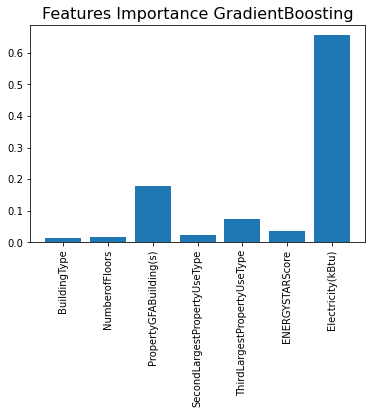

In [184]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

grid=GradientBoostingRegressor(n_estimators=1000,learning_rate=0.02)
grid.fit(X_train, y_train)

plt.bar(range(len(X.columns.tolist())),grid.feature_importances_,)
plt.title('Features Importance GradientBoosting',size=16)
plt.xticks(range(len(X.columns.tolist())),X.columns.tolist(),rotation=90)

plt.show() 

In [106]:
#On garde le tout:
data=pd.read_csv("cleaneddata.csv")

In [186]:
data.head()

,Unnamed: 0,OSEBuildingID,BuildingType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,OtherFuelUse(kBtu)
0,0,1,1,47.612195,-122.337994,1927,1.0,12.0,0.000000,11.390012,0.0,0.000000,3.374911,62.0,7103895.25,0.537178,0.179396,249.705,0.0
1,1,2,1,47.613138,-122.333644,1996,1.0,11.0,9.620129,11.390780,0.0,8.438799,3.367069,56.0,8371084.00,0.426957,0.573043,279.685,0.0
2,5,9,1,47.616334,-122.336667,1999,1.0,2.0,10.524037,11.003599,0.0,0.000000,3.375573,NaN,12069300.00,0.606591,0.393409,303.215,0.0
3,6,10,1,47.614007,-122.332785,1926,1.0,11.0,0.000000,11.326692,0.0,0.000000,3.362522,26.0,6005818.50,0.457129,0.542871,192.300,0.0
4,7,11,1,47.613086,-122.331335,1926,1.0,8.0,0.000000,11.540161,0.0,0.000000,3.397083,NaN,6362076.75,0.608650,0.055034,210.750,0.0


In [107]:
data.shape

(2692, 19)

In [108]:
#On va commencer par effectuer les différences régression avec l'EnergyStarScore:
#On commence par l'énergie
data=data[data.columns.tolist()[2:]]
data.drop(['NumberofBuildings','OtherFuelUse(kBtu)'],axis=1,inplace=True)

In [109]:
#Après quelques essais avec ou sans ESS, la prédiction de l'énergie est bien meilleure avec ESS
#Et on ne nous demande d'étudier ESS que pour les émissions:

data.dropna(how='any',inplace=True)

X=data[['BuildingType','NumberofFloors','PropertyGFABuilding(s)','SecondLargestPropertyUseType',\
       'ThirdLargestPropertyUseType','ENERGYSTARScore','Electricity(kBtu)']]
y=data['TotalGHGEmissions']


y.describe()

count    2089.000000
mean       53.258889
std        68.998781
min         0.640000
25%         8.180000
50%        26.365000
75%        67.365000
max       395.895000
Name: TotalGHGEmissions, dtype: float64

In [191]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xtrain,Xtest,ytrain,y_test=train_test_split(X,y,test_size=0.25)

std=StandardScaler()
std.fit(Xtrain)
#On standardise
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log(ytrain)


In [192]:
#On va effectuer quelques GridSearch pour sélectionner des hyperparamètre en KernelRidge, SVR
#On va prendre comme scoring la R2:

Score=pd.DataFrame({'Best Parameters':[],'R2':[]})

In [193]:
#KernelRidge:
#Linear pas de bons scores
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

for i in ['rbf', 'sigmoid']:
    params={'gamma':np.logspace(-8, -2, 6),'alpha':np.logspace(-8, -4, 8)}

    kr = GridSearchCV(KernelRidge(kernel=i),params,cv=2,scoring='r2')
    kr.fit(X_train, y_train)
    
    k='KernelRidge '+i
    Score.loc[k]=pd.Series({'Best Parameters':kr.best_params_,'R2':kr.best_score_})
    print("The optimal parameters are {} with a score of {:.2f}".format(kr.best_params_, kr.best_score_))

The optimal parameters are {'alpha': 5.179474679231213e-07, 'gamma': 0.000630957344480193} with a score of 0.91


Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least

The optimal parameters are {'alpha': 3.7275937203149377e-08, 'gamma': 0.000630957344480193} with a score of 0.91


In [195]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

params={'degree':[2,3,4,5],'gamma':np.logspace(-5, -1, 6),'alpha':np.logspace(-4, 2, 6)}

kr = GridSearchCV(KernelRidge(kernel='poly'),params,cv=2,scoring='r2')
kr.fit(X_train, y_train)
Score.loc['KernelRidge Polynomiale']=pd.Series({'Best Parameters':kr.best_params_,'R2':kr.best_score_})
print(kr.best_params_,kr.best_score_)

{'alpha': 0.025118864315095794, 'degree': 4, 'gamma': 0.01584893192461114} 0.9099926544703212


In [198]:
Score

,Best Parameters,R2
KernelRidge rbf,"{'alpha': 5.179474679231213e-07, 'gamma': 0.00...",0.909396
KernelRidge sigmoid,"{'alpha': 3.7275937203149377e-08, 'gamma': 0.0...",0.908653
KernelRidge Polynomiale,"{'alpha': 0.025118864315095794, 'degree': 4, '...",0.909993
SVR linear,"{'C': 10.0, 'gamma': 1e-06}",0.873346
SVR rbf,"{'C': 1000.0, 'gamma': 0.0021544346900318843}",0.904808
SVR sigmoid,"{'C': 1000.0, 'gamma': 4.641588833612782e-05}",0.873794


In [199]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

for i in ['rbf', 'sigmoid']:
    params={'gamma':np.logspace(-6, -1, 4),'C':np.logspace(2, 4, 4)}

    grid = GridSearchCV(SVR(kernel=i),params,cv=2,scoring='r2')
    print(i)
    grid.fit(X_train, y_train)
    
    k='SVR '+i
    Score.loc[k]=pd.Series({'Best Parameters':grid.best_params_,'R2':grid.best_score_})
    print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))
    

rbf
The optimal parameters are {'C': 10000.0, 'gamma': 0.0021544346900318843} with a score of 0.91
sigmoid
The optimal parameters are {'C': 464.15888336127773, 'gamma': 4.641588833612782e-05} with a score of 0.87


In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

params={'C':np.logspace(-2, 3, 2)}

grid = GridSearchCV(SVR(kernel='poly',degree=4,gamma='auto'),params,cv=2,scoring='r2')
grid.fit(X_train, y_train)
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))


The optimal parameters are {'C': 0.01} with a score of 0.15


In [200]:
for i in range(Score.shape[0]):
    print(Score.iloc[i]['Best Parameters'])

{'alpha': 5.179474679231213e-07, 'gamma': 0.000630957344480193}
{'alpha': 3.7275937203149377e-08, 'gamma': 0.000630957344480193}
{'alpha': 0.025118864315095794, 'degree': 4, 'gamma': 0.01584893192461114}
{'C': 10.0, 'gamma': 1e-06}
{'C': 10000.0, 'gamma': 0.0021544346900318843}
{'C': 464.15888336127773, 'gamma': 4.641588833612782e-05}


In [201]:
Score

,Best Parameters,R2
KernelRidge rbf,"{'alpha': 5.179474679231213e-07, 'gamma': 0.00...",0.909396
KernelRidge sigmoid,"{'alpha': 3.7275937203149377e-08, 'gamma': 0.0...",0.908653
KernelRidge Polynomiale,"{'alpha': 0.025118864315095794, 'degree': 4, '...",0.909993
SVR linear,"{'C': 10.0, 'gamma': 1e-06}",0.873346
SVR rbf,"{'C': 10000.0, 'gamma': 0.0021544346900318843}",0.906186
SVR sigmoid,"{'C': 464.15888336127773, 'gamma': 4.641588833...",0.873800


In [103]:
X.columns

Index(['BuildingType', 'Latitude', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'Electricity(kBtu)'],
      dtype='object')

Singular matrix in solving dual problem. Using least-squares solution instead.


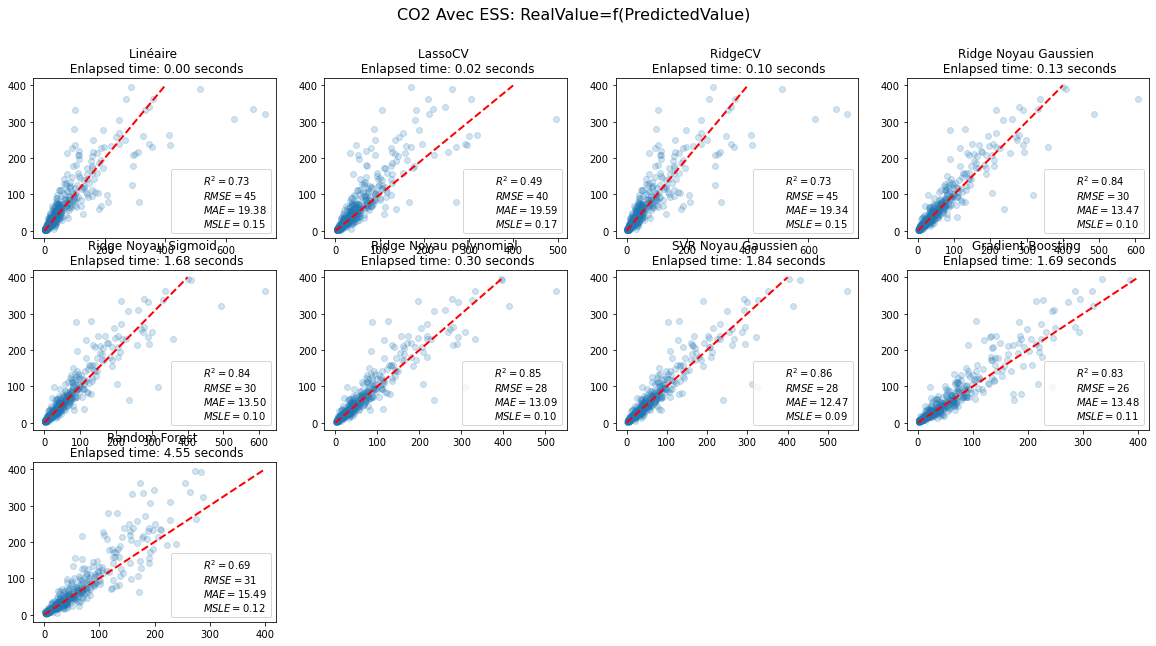

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR #OK
from sklearn.kernel_ridge import KernelRidge#OK
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV#OK
from sklearn.ensemble import GradientBoostingRegressor#OK
from sklearn.ensemble import RandomForestRegressor#OK
from sklearn.ensemble import AdaBoostRegressor#OK
import time
import xgboost

Xtrain,Xtest,ytrain,y_test=train_test_split(X,y,test_size=0.25)

std=StandardScaler()
std.fit(Xtrain)
#On standardise
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log(ytrain)


regressors=[LinearRegression(),LassoCV(alphas=np.logspace(-1,3,10),cv=5)\
            ,RidgeCV(np.logspace(-1,3,10),cv=5),KernelRidge(kernel='rbf',alpha=5*10**(-7),gamma=0.0006),\
           KernelRidge(kernel='sigmoid',alpha=4*10**(-8),gamma=0.0006),\
           KernelRidge(kernel='poly',degree=4,alpha=0.025,gamma=0.015),SVR(kernel='rbf',gamma=0.002,C=10000),\
           GradientBoostingRegressor(n_estimators=1000,learning_rate=0.02),RandomForestRegressor(n_estimators=1000),\
            AdaBoostRegressor(n_estimators=500)]

name=['Linéaire','LassoCV','RidgeCV','Ridge Noyau Gaussien','Ridge Noyau Sigmoid','Ridge Noyau polynomial','SVR Noyau Gaussien',\
     'Gradient Boosting','Random Forest','Adaboost']

Result=pd.DataFrame({'R2':[],'RMSE':[],'MAE':[],'MSLE':[],'Temps':[]})

k=1

fig=plt.figure(figsize=(20,10))
plt.suptitle('CO2 Avec ESS: RealValue=f(PredictedValue)',size=16)

for i in range(9):
    start=time.time()
    estimator=regressors[i]
    estimator.fit(X_train,y_train)
    y_pred=np.expm1(estimator.predict(X_test))
    
    t=time.time()-start
    R2=r2_score(y_pred,y_test)
    MSE=mean_squared_error(y_pred,y_test)
    MAE=mean_absolute_error(y_pred,y_test)
    MSLE=mean_squared_log_error(y_pred,y_test)
    
    
    Result.loc[name[i]]=pd.Series({'R2':R2,'RMSE':MSE**0.5,'MAE':MAE,'MSLE':MSLE,'Temps':t})

    plt.subplot(3,4,k)
    plt.plot([0,400],[0,400],'--r', linewidth=2)
    plt.scatter(y_pred,y_test,alpha=0.2)
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
    plt.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.0f}$'+ '\n' + r'$MAE={:.2f}$'+ '\n' + r'$MSLE={:.2f}$').\
                 format(R2,MSE**0.5,MAE,MSLE)], loc='lower right')
    
    plt.title(('{} \n Enlapsed time: {:.2f} seconds').format(name[i],t),size=12)
    
    k+=1
    
plt.show()

## On reagarde maintenant sans l'ESS

In [81]:

data=pd.read_csv("cleaneddata.csv")

In [82]:
data=data.reset_index(drop=True)


In [83]:
data=data.iloc[np.random.permutation(data.index)].reset_index(drop=True)
#On mélange le dataset pour la sélection de Xtrain et Xtest pour la sélection des features
data.head()

,Unnamed: 0,OSEBuildingID,BuildingType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,OtherFuelUse(kBtu)
0,2302,25259,0,47.709571,-122.310696,1995,1.0,2.0,0.000000,10.363441,0.0,0.0,3.219235,100.0,2401487.875,0.609712,0.390288,59.985,0.0
1,571,778,1,47.598086,-122.333688,1910,1.0,6.0,9.525224,11.305901,0.0,0.0,3.368129,83.0,4080621.500,0.962882,0.037118,35.435,0.0
2,2719,26832,0,47.597265,-122.325401,1979,1.0,8.0,0.000000,11.231583,0.0,0.0,3.351357,15.0,4516803.000,0.695614,0.304386,94.925,0.0
3,2981,27868,0,47.614341,-122.309206,1988,1.0,4.0,7.383057,10.183862,0.0,0.0,3.181392,58.0,753596.000,1.000000,0.000000,5.250,0.0
4,2066,24431,0,47.619046,-122.322465,1928,1.0,4.0,0.000000,10.616437,0.0,0.0,3.258291,84.0,2404984.000,0.166813,0.833187,109.215,0.0


In [84]:
data=data[data.columns.tolist()[2:]]
data.drop(['ENERGYSTARScore'],axis=1,inplace=True)
data.isnull().sum()

BuildingType                    0
Latitude                        0
Longitude                       0
YearBuilt                       0
NumberofBuildings               0
NumberofFloors                  0
PropertyGFAParking              0
PropertyGFABuilding(s)          0
LargestPropertyUseType          0
SecondLargestPropertyUseType    0
ThirdLargestPropertyUseType     0
SiteEnergyUse(kBtu)             0
Electricity(kBtu)               0
NaturalGas(kBtu)                0
TotalGHGEmissions               0
OtherFuelUse(kBtu)              0
dtype: int64

In [85]:
data.shape

(2692, 16)

In [86]:
#Après quelques essais avec ou sans ESS, la prédiction de l'énergie est bien meilleure avec ESS
#Et on ne nous demande d'étudier ESS que pour les émissions:

X=data.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y=data['TotalGHGEmissions']



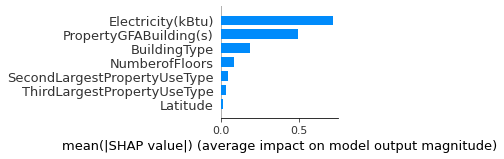

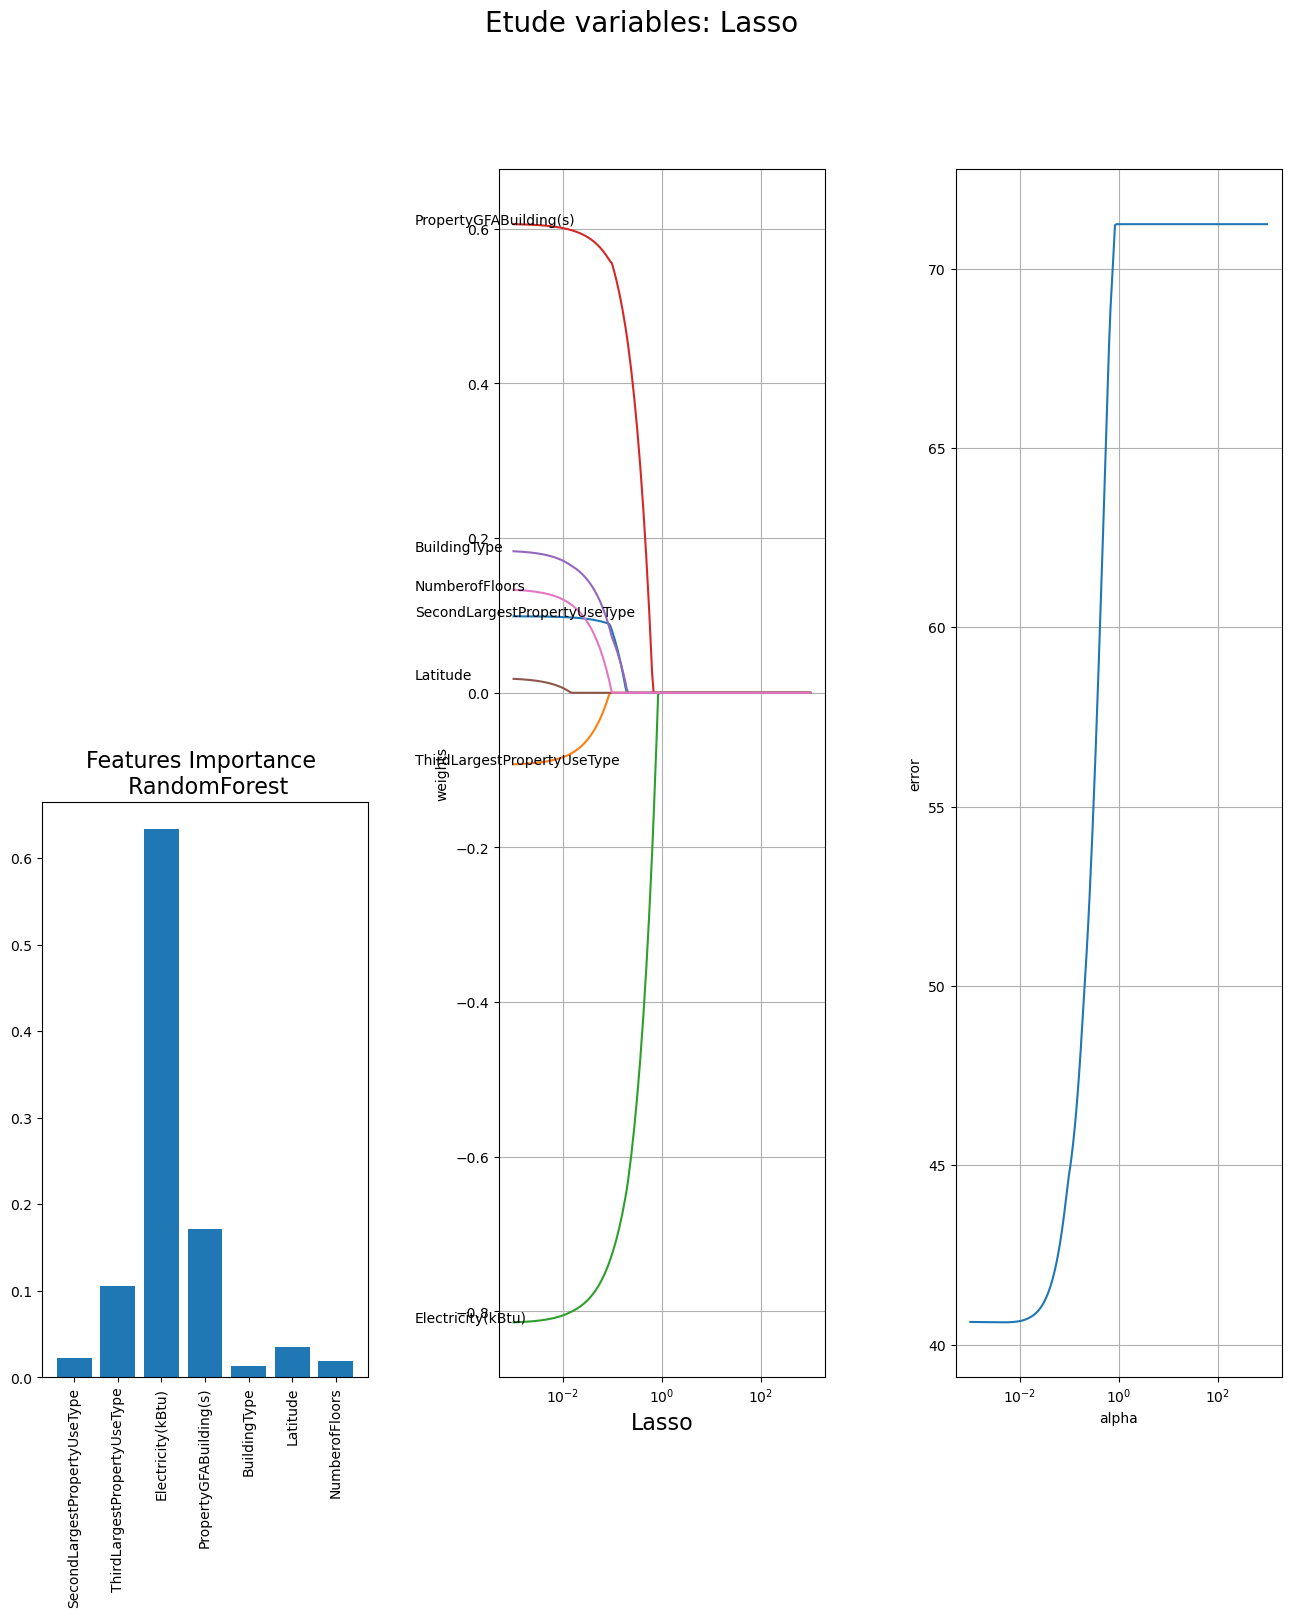

,R2,RMSE,MAE,MSLE
Dummy,0.000000,71.238876,41.138092,1.418439
Regression Simple,0.553172,40.638405,20.065864,0.260201
Régression Ridge,0.550584,40.583715,20.046912,0.260164
Régression Lasso,0.034035,44.777050,22.117814,0.309663
Random Forrest,0.521059,35.623480,18.253365,0.244809


In [88]:
#Je recrée mes échantillon test en prenant les 1600 premiere lignes pour le train et le reste pour le test:
X=data[['SecondLargestPropertyUseType','ThirdLargestPropertyUseType','Electricity(kBtu)',\
        'PropertyGFABuilding(s)','BuildingType','Latitude','NumberofFloors']]
y=data['TotalGHGEmissions']
#,,'NaturalGas(kBtu)',,'Latitude','YearBuilt'
#J'enlève les features pour voir l'effet sur les prédictions:

#Je relance mes algorithmes
from sklearn.preprocessing import StandardScaler

#On standardise
Xtrain=X.iloc[1:2100,:]
Xtest=X.iloc[2100:,:]

std=StandardScaler()
std.fit(Xtrain)
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log1p(y.iloc[1:2100])
y_test=y.iloc[2100:]


from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

result=pd.DataFrame({'R2':[],'RMSE':[],'MAE':[],'MSLE':[]})


dum_sans=DummyRegressor(strategy='mean')
dum_sans.fit(X_train,y_train)
#On passe à l'exponentielle pour comparer avec les valeurs test qui n'ont pas été passées au log
y_pred=np.expm1(dum_sans.predict(X_test))
    
result.loc['Dummy']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})


import shap
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
    
lr.fit(X_train,y_train)
y_pred=np.expm1(lr.predict(X_test))

result.loc['Regression Simple']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})


explainer= shap.LinearExplainer(lr,X_train,1000)
shap_values= explainer.shap_values(X_train)

fig=plt.figure(figsize=(14,6))

grid=plt.GridSpec(2,3,wspace=0.4,hspace=0.1)

plt.subplot(grid[0,0])
shap.summary_plot(shap_values, X.columns, plot_type="bar")
#On va faire un Ridge CV en regardant un peu l'efficacité des variables:
from sklearn.linear_model import RidgeCV

lr=RidgeCV(alphas=np.logspace(-1,3,200),cv=10)
    
lr.fit(X_train,y_train)
y_pred=np.expm1(lr.predict(X_test))
    
result.loc['Régression Ridge']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

from sklearn.linear_model import LassoCV



lr=LassoCV(alphas=np.logspace(-1,3,200),cv=10)
    
lr.fit(X_train,y_train)
y_pred=np.expm1(lr.predict(X_test))

result.loc['Régression Lasso']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

#On va regarder un peu plus les variables:
n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)

from sklearn.linear_model import Lasso

lasso = Lasso()
    
i=0
coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train,y_train)
    y_pred=np.expm1(lasso.predict(X_test))
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred - y_test) ** 2)**0.5)

fig = plt.figure(2, figsize=(16, 16), frameon=False, dpi=100)
k=1
plt.suptitle('Etude variables: Lasso',size=20)

plt.subplot(grid[:,1])
ax = plt.gca()
for i in range(X.shape[1]):
    ax.plot(alphas, [coefs[k][i] for k in range(200)])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.xlabel('Lasso',size=16)
plt.ylabel('weights')
plt.axis('tight')
plt.grid(True)
#On affiche le nom de la feature avec ciefs[0][i]
for i in range(X.shape[1]):
    plt.text(0.00001, coefs[0][i], X.columns.tolist()[i],transform=ax.transData)
    

plt.subplot(grid[:,2])
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.grid(True)


#On va faire un randomForrestRegressor:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=1000)

rf.fit(X_train, y_train)
y_pred=np.exp(rf.predict(X_test))

result.loc['Random Forrest']=pd.Series({'R2':r2_score(y_pred,y_test),'RMSE':mean_squared_error(y_pred,y_test)**0.5,\
                          'MAE':mean_absolute_error(y_pred,y_test),'MSLE':mean_squared_log_error(y_pred,y_test)})

plt.subplot(grid[1,0])

plt.bar(range(len(X.columns.tolist())),rf.feature_importances_,)
plt.title('Features Importance \n RandomForest',size=16)
plt.xticks(range(len(X.columns.tolist())),X.columns.tolist(),rotation=90)

plt.show() 

result

In [26]:
# Voici les résultats avec Building type, number of floors, GFABuilding, Second et Third, elec et gas naturel:
result

,R2,RMSE,MAE,MSLE
Dummy,-4.803160e+32,77.861671,43.714717,1.450183
Regression Simple,5.770772e-01,47.832535,20.882050,0.209705
Régression Ridge,5.752395e-01,47.656438,20.872244,0.209842
Régression Lasso,-4.691884e-02,49.995596,23.266824,0.264830
Random Forrest,5.644949e-01,36.962902,18.065755,0.209922


In [24]:
#On enlève LargestPropertyUse, OtherFuelUse et NumberofBuildings
result

,R2,RMSE,MAE,MSLE
Dummy,-4.803160e+32,77.861671,43.714717,1.450183
Regression Simple,5.802832e-01,46.768235,20.510483,0.204944
Régression Ridge,5.782385e-01,46.596594,20.514017,0.205123
Régression Lasso,-4.691884e-02,49.995596,23.266824,0.264830
Random Forrest,5.450804e-01,36.893922,17.713880,0.199384


In [13]:

#C'est mieux
#Voici les résultats avec toutes les features:
result

,R2,RMSE,MAE,MSLE
Dummy,-4.585781e+32,76.079359,43.919069,1.537918
Regression Simple,4.723847e-01,51.961263,22.992295,0.303814
Régression Ridge,4.703968e-01,51.942281,22.993253,0.303931
Régression Lasso,-1.200270e-01,50.324963,24.333501,0.348899
Random Forrest,4.121968e-01,40.578355,20.398206,0.292640


In [ ]:
#On regarde avec GradientBoosting:

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

params={'n_estimators':[500,1000,5000], 
            'learning_rate': [0.05,0.02,0.01]}

grid = GridSearchCV(GradientBoostingRegressor(),params,cv=2,scoring='r2')
grid.fit(X_train, y_train)
    
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))



The optimal parameters are {'learning_rate': 0.01, 'n_estimators': 1000} with a score of 0.84


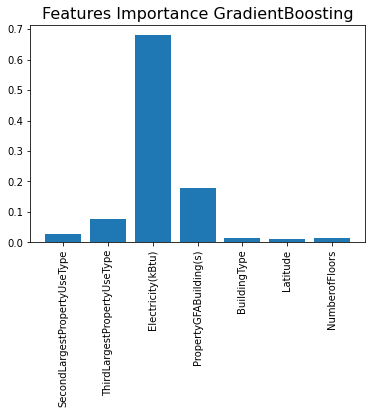

In [90]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

grid=GradientBoostingRegressor(n_estimators=1000,learning_rate=0.01)
grid.fit(X_train, y_train)

plt.bar(range(len(X.columns.tolist())),grid.feature_importances_,)
plt.title('Features Importance GradientBoosting',size=16)
plt.xticks(range(len(X.columns.tolist())),X.columns.tolist(),rotation=90)

plt.show() 

In [91]:
#On garde le tout:
data=pd.read_csv("cleaneddata.csv")

In [92]:
data.head()

,Unnamed: 0,OSEBuildingID,BuildingType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,OtherFuelUse(kBtu)
0,0,1,1,47.612195,-122.337994,1927,1.0,12.0,0.000000,11.390012,0.0,0.000000,3.374911,62.0,7103895.25,0.537178,0.179396,249.705,0.0
1,1,2,1,47.613138,-122.333644,1996,1.0,11.0,9.620129,11.390780,0.0,8.438799,3.367069,56.0,8371084.00,0.426957,0.573043,279.685,0.0
2,5,9,1,47.616334,-122.336667,1999,1.0,2.0,10.524037,11.003599,0.0,0.000000,3.375573,NaN,12069300.00,0.606591,0.393409,303.215,0.0
3,6,10,1,47.614007,-122.332785,1926,1.0,11.0,0.000000,11.326692,0.0,0.000000,3.362522,26.0,6005818.50,0.457129,0.542871,192.300,0.0
4,7,11,1,47.613086,-122.331335,1926,1.0,8.0,0.000000,11.540161,0.0,0.000000,3.397083,NaN,6362076.75,0.608650,0.055034,210.750,0.0


In [93]:
data.shape

(2692, 19)

In [94]:
#On va commencer par effectuer les différences régression avec l'EnergyStarScore:
#On commence par l'énergie
data=data[data.columns.tolist()[2:]]
data.drop(['NumberofBuildings','OtherFuelUse(kBtu)'],axis=1,inplace=True)

In [95]:
#Après quelques essais avec ou sans ESS, la prédiction de l'énergie est bien meilleure avec ESS
#Et on ne nous demande d'étudier ESS que pour les émissions:

data.dropna(how='any',inplace=True)

X=data[['SecondLargestPropertyUseType','ThirdLargestPropertyUseType','Electricity(kBtu)','PropertyGFABuilding(s)','BuildingType']]
y=data['TotalGHGEmissions']


y.describe()

count    2089.000000
mean       53.258889
std        68.998781
min         0.640000
25%         8.180000
50%        26.365000
75%        67.365000
max       395.895000
Name: TotalGHGEmissions, dtype: float64

In [96]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xtrain,Xtest,ytrain,y_test=train_test_split(X,y,test_size=0.25)

std=StandardScaler()
std.fit(Xtrain)
#On standardise
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log(ytrain)


In [97]:
#On va effectuer quelques GridSearch pour sélectionner des hyperparamètre en KernelRidge, SVR
#On va prendre comme scoring la R2:

Score=pd.DataFrame({'Best Parameters':[],'R2':[]})

In [98]:
#KernelRidge:
#Linear pas de bons scores
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

for i in ['rbf', 'sigmoid']:
    params={'gamma':np.logspace(-8, -2, 6),'alpha':np.logspace(-8, -4, 8)}

    kr = GridSearchCV(KernelRidge(kernel=i),params,cv=2,scoring='r2')
    kr.fit(X_train, y_train)
    
    k='KernelRidge '+i
    Score.loc[k]=pd.Series({'Best Parameters':kr.best_params_,'R2':kr.best_score_})
    print("The optimal parameters are {} with a score of {:.2f}".format(kr.best_params_, kr.best_score_))

The optimal parameters are {'alpha': 5.179474679231213e-07, 'gamma': 0.000630957344480193} with a score of 0.86


Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least-squares solution instead.
Singular matrix in solving dual problem. Using least

The optimal parameters are {'alpha': 3.7275937203149377e-08, 'gamma': 0.000630957344480193} with a score of 0.86


In [99]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

params={'degree':[2,3,4,5],'gamma':np.logspace(-5, -1, 6),'alpha':np.logspace(-4, 2, 6)}

kr = GridSearchCV(KernelRidge(kernel='poly'),params,cv=2,scoring='r2')
kr.fit(X_train, y_train)
Score.loc['KernelRidge Polynomiale']=pd.Series({'Best Parameters':kr.best_params_,'R2':kr.best_score_})
print(kr.best_params_,kr.best_score_)

{'alpha': 0.0001, 'degree': 4, 'gamma': 0.002511886431509582} 0.8633868295955018


In [198]:
Score

,Best Parameters,R2
KernelRidge rbf,"{'alpha': 5.179474679231213e-07, 'gamma': 0.00...",0.909396
KernelRidge sigmoid,"{'alpha': 3.7275937203149377e-08, 'gamma': 0.0...",0.908653
KernelRidge Polynomiale,"{'alpha': 0.025118864315095794, 'degree': 4, '...",0.909993
SVR linear,"{'C': 10.0, 'gamma': 1e-06}",0.873346
SVR rbf,"{'C': 1000.0, 'gamma': 0.0021544346900318843}",0.904808
SVR sigmoid,"{'C': 1000.0, 'gamma': 4.641588833612782e-05}",0.873794


In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

for i in ['rbf', 'sigmoid']:
    params={'gamma':np.logspace(-6, -1, 4),'C':np.logspace(2, 5, 5)}

    grid = GridSearchCV(SVR(kernel=i),params,cv=2,scoring='r2')
    print(i)
    grid.fit(X_train, y_train)
    
    k='SVR '+i
    Score.loc[k]=pd.Series({'Best Parameters':grid.best_params_,'R2':grid.best_score_})
    print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))
    

rbf
The optimal parameters are {'C': 17782.794100389227, 'gamma': 0.0021544346900318843} with a score of 0.86
sigmoid
The optimal parameters are {'C': 562.341325190349, 'gamma': 4.641588833612782e-05} with a score of 0.84


In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

params={'C':np.logspace(-2, 3, 2)}

grid = GridSearchCV(SVR(kernel='poly',degree=4,gamma='auto'),params,cv=2,scoring='r2')
grid.fit(X_train, y_train)
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))


The optimal parameters are {'C': 0.01} with a score of 0.22


In [101]:
for i in range(Score.shape[0]):
    print(Score.iloc[i]['Best Parameters'])

{'alpha': 5.179474679231213e-07, 'gamma': 0.000630957344480193}
{'alpha': 3.7275937203149377e-08, 'gamma': 0.000630957344480193}
{'alpha': 0.0001, 'degree': 4, 'gamma': 0.002511886431509582}
{'C': 17782.794100389227, 'gamma': 0.0021544346900318843}
{'C': 562.341325190349, 'gamma': 4.641588833612782e-05}


In [102]:
Score

,Best Parameters,R2
KernelRidge rbf,"{'alpha': 5.179474679231213e-07, 'gamma': 0.00...",0.862838
KernelRidge sigmoid,"{'alpha': 3.7275937203149377e-08, 'gamma': 0.0...",0.862187
KernelRidge Polynomiale,"{'alpha': 0.0001, 'degree': 4, 'gamma': 0.0025...",0.863387
SVR rbf,"{'C': 17782.794100389227, 'gamma': 0.002154434...",0.859674
SVR sigmoid,"{'C': 562.341325190349, 'gamma': 4.64158883361...",0.838960


In [64]:
X.columns

Index(['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'Electricity(kBtu)', 'PropertyGFABuilding(s)', 'BuildingType'],
      dtype='object')

Singular matrix in solving dual problem. Using least-squares solution instead.


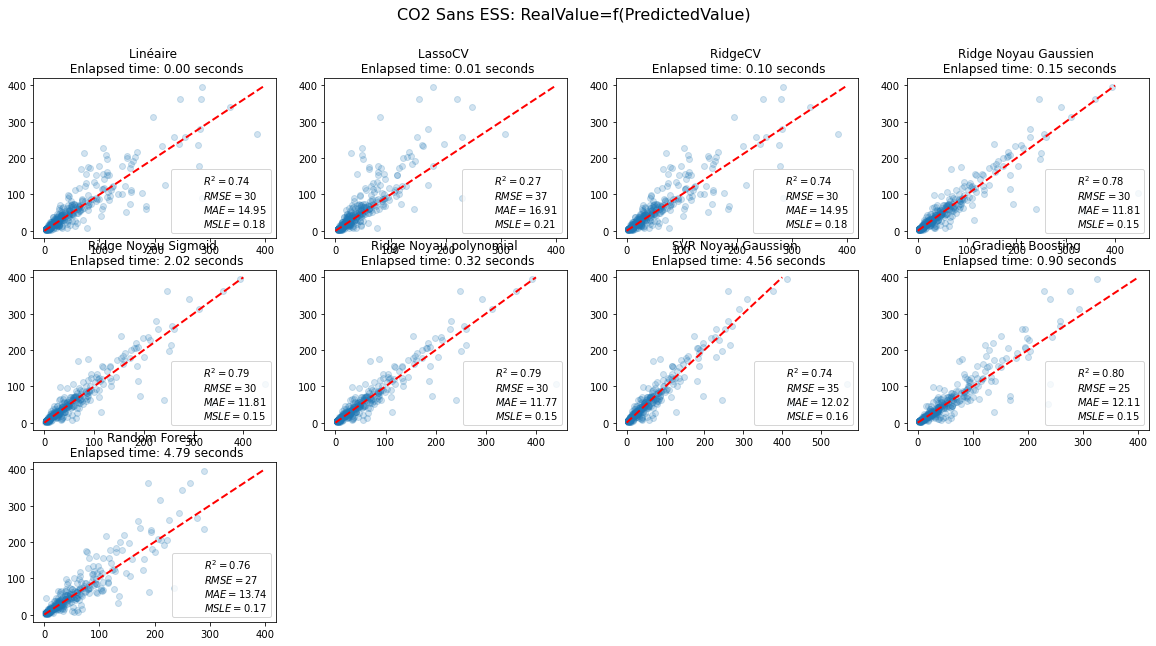

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR #OK
from sklearn.kernel_ridge import KernelRidge#OK
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV#OK
from sklearn.ensemble import GradientBoostingRegressor#OK
from sklearn.ensemble import RandomForestRegressor#OK
from sklearn.ensemble import AdaBoostRegressor#OK
import time
import xgboost

Xtrain,Xtest,ytrain,y_test=train_test_split(X,y,test_size=0.2)

std=StandardScaler()
std.fit(Xtrain)
#On standardise
X_train=std.transform(Xtrain)
X_test=std.transform(Xtest)
#On normalise y_train
y_train=np.log(ytrain)


regressors=[LinearRegression(),LassoCV(alphas=np.logspace(-1,3,10),cv=5)\
            ,RidgeCV(np.logspace(-1,3,10),cv=5),KernelRidge(kernel='rbf',alpha=5*10**(-7),gamma=0.0006),\
           KernelRidge(kernel='sigmoid',alpha=4*10**(-8),gamma=0.0006),\
           KernelRidge(kernel='poly',degree=4,alpha=0.0001,gamma=0.0025),SVR(kernel='rbf',gamma=0.002,C=20000),\
           GradientBoostingRegressor(n_estimators=500,learning_rate=0.02),RandomForestRegressor(n_estimators=1000),\
            AdaBoostRegressor(n_estimators=500)]

name=['Linéaire','LassoCV','RidgeCV','Ridge Noyau Gaussien','Ridge Noyau Sigmoid','Ridge Noyau polynomial','SVR Noyau Gaussien',\
     'Gradient Boosting','Random Forest','Adaboost']

Result=pd.DataFrame({'R2':[],'RMSE':[],'MAE':[],'MSLE':[],'Temps':[]})

k=1

fig=plt.figure(figsize=(20,10))
plt.suptitle('CO2 Sans ESS: RealValue=f(PredictedValue)',size=16)

for i in range(9):
    start=time.time()
    estimator=regressors[i]
    estimator.fit(X_train,y_train)
    y_pred=np.expm1(estimator.predict(X_test))
    
    t=time.time()-start
    R2=r2_score(y_pred,y_test)
    MSE=mean_squared_error(y_pred,y_test)
    MAE=mean_absolute_error(y_pred,y_test)
    MSLE=mean_squared_log_error(y_pred,y_test)
    
    
    Result.loc[name[i]]=pd.Series({'R2':R2,'RMSE':MSE**0.5,'MAE':MAE,'MSLE':MSLE,'Temps':t})

    plt.subplot(3,4,k)
    plt.plot([0,400],[0,400],'--r', linewidth=2)
    plt.scatter(y_pred,y_test,alpha=0.2)
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
    plt.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.0f}$'+ '\n' + r'$MAE={:.2f}$'+ '\n' + r'$MSLE={:.2f}$').\
                 format(R2,MSE**0.5,MAE,MSLE)], loc='lower right')
    
    plt.title(('{} \n Enlapsed time: {:.2f} seconds').format(name[i],t),size=12)
    
    k+=1
    
plt.show()